use file cox-parsed_7214rows_with_labels.csv
It contains predicted and ground truth used in propublica
compute the fairness metrics by compas_screening_date

# get all time stamps

In [1]:
# First, install the autoreload extension
%load_ext autoreload
# Set autoreload to automatically reload modules
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from algorithm import CR_0_20240118 as CR
from algorithm import CR_baseline_0_20240118 as CR_baseline



# read data

In [2]:
data = pd.read_csv('../../data/compas/preprocessed/cox-parsed_7214rows_with_labels_sorted_by_dates.csv')

In [25]:
data[:30]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,in_custody,out_custody,priors_count.1,start,end,event,predicted,ground_truth,window_key,new_window
0,10686,martin martinez,martin,martinez,2013-01-01,Male,1980-01-06,36,25 - 45,Caucasian,...,2013-01-01,2013-02-06,0,36,1186,0,0,0,None,True
1,5084,regina battle,regina,battle,2013-01-01,Female,1988-06-28,27,25 - 45,African-American,...,NaN,NaN,0,0,1186,0,0,0,None,True
2,604,devaughn brown,devaughn,brown,2013-01-01,Male,1993-07-25,22,Less than 25,African-American,...,2013-12-30,2014-01-10,0,21,363,0,1,1,None,True
3,16,kortney coleman,kortney,coleman,2013-01-01,Female,1978-08-22,37,25 - 45,Caucasian,...,2013-01-01,2013-01-02,0,1,1186,0,0,0,None,True
4,9339,william mulligan,william,mulligan,2013-01-01,Male,1986-10-25,29,25 - 45,Caucasian,...,2013-01-04,2013-01-05,1,0,2,1,0,1,None,True
5,1196,kevin kendall,kevin,kendall,2013-01-01,Male,1984-09-16,31,25 - 45,Caucasian,...,2013-01-01,2013-01-06,0,5,1186,0,0,0,None,True
6,5193,dorean nairn,dorean,nairn,2013-01-01,Female,1979-11-15,36,25 - 45,African-American,...,2013-03-16,2013-03-16,5,1,74,0,1,1,None,True
7,5507,patwayne walters,patwayne,walters,2013-01-01,Male,1972-10-24,43,25 - 45,Other,...,NaN,NaN,2,0,1186,0,0,0,None,True
8,820,terrance holland,terrance,holland,2013-01-01,Male,1984-01-11,32,25 - 45,Hispanic,...,2013-01-01,2013-01-02,20,1,1186,0,1,0,None,True
9,1704,susana colon,susana,colon,2013-01-01,Female,1966-10-17,49,Greater than 45,Caucasian,...,2013-05-08,2013-05-08,0,0,127,0,0,1,None,True


<Axes: >

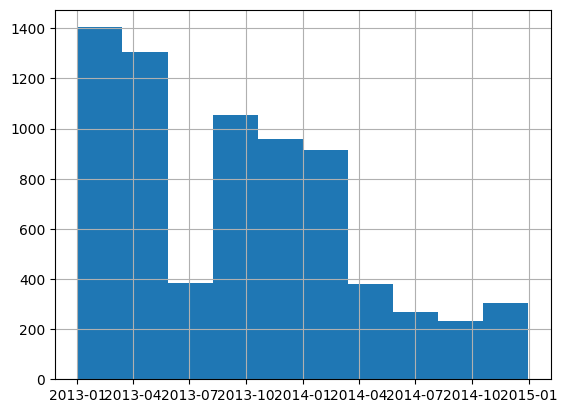

In [26]:
# get distribution of compas_screening_date
data['compas_screening_date'] = pd.to_datetime(data['compas_screening_date'])
data['compas_screening_date'].hist()

In [27]:
# # get the month and year of the date
# data['month'] = data['compas_screening_date'].apply(lambda x: x.month)
# data['year'] = data['compas_screening_date'].apply(lambda x: x.year)
# print(data['month'][:4])

In [28]:
# # get data with in the first month
# data_first_month = data[data['compas_screening_date'] < '2013-08-01']

# process time series

In [32]:
# use CR to monitor tpr of different races over time
# a time window is a month

# Function to compute the time window key (e.g., year-month for 'month' windows)
def compute_time_window_key(row, window_type):
    print(window_type)
    if window_type == 'year':
        return row.year
    elif window_type == 'month':
        return f"{row.year}-{row.month}"
    elif window_type == 'week':
        return f"{row.year}-{row.week}"
    elif window_type == 'day':
        return f"{row.year}-{row.month}-{row.day}"

def belong_to_group(row, group):
    for key in group.keys():
        if row[key] != group[key]:
            return False
    return True

def monitorCR(timed_data, date_column, time_window_str, monitored_groups, threshold, alpha):

    units = {'month': 'M', 'year': 'Y', 'day': 'D', 'week': 'W'}
    number, unit = time_window_str.split()
    unit = units[unit]  # Convert to pandas offset alias
    
    
    # Apply the function to compute the window key for each row
    timed_data['window_key'] = timed_data[date_column].apply(compute_time_window_key, args=(unit,))
    print(timed_data['window_key'][:10])
    # Determine the start of a new window
    timed_data['new_window'] = timed_data['window_key'] != timed_data['window_key'].shift(1)
    
    DFMonitor = CR.DF_CR(monitored_groups, alpha, threshold)
    DFMonitor.print()
    first_row_index = timed_data.index[0]  # Get the index of the first row
    counters = [0] * len(monitored_groups)
    total_counter = 0
    first_window_processed = False
    
    def process_each_tuple(row, DFMonitor, first_row_index):
        nonlocal counters
        nonlocal total_counter
        nonlocal first_window_processed
        # print(row['race'])
        if row.name == first_row_index:  # initialization
            total_counter += 1
            for group in monitored_groups:
                if belong_to_group(row, group):
                    counters[monitored_groups.index(group)] += 1
        elif row['new_window']:  # new window
            DFMonitor.print()
            if not first_window_processed:
                uf = [True if counters[i]/total_counter > threshold else False for i in range(len(counters))]
                delta = [abs(threshold * total_counter - counters[i]) * alpha for i in range(len(counters))]
                DFMonitor.initialization(uf, delta)
                first_window_processed = True
            else:
                DFMonitor.new_window()
            DFMonitor.insert(row)
        return 
    
    timed_data.apply(process_each_tuple, axis=1, args=(DFMonitor, first_row_index,))
    


In [33]:

monitored_groups = [{"race": 'African-American'}, {"race": 'Caucasian'}]
alpha = 0.5
threshold = 0.1
monitorCR(data, "compas_screening_date", "1 month", monitored_groups, threshold, alpha)



M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
M
